In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score



%matplotlib inline


In [2]:
sale_price_train = pd.read_csv("train.csv", index_col='Id')
sale_price_train.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Checking if duplicates existed

In [3]:
sale_price_train.duplicated().any()

False

In [4]:
sale_price_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

## Splitting data into categorical and non-categorical(continuous) columns

In [5]:
continuous_cols= list(sale_price_train.describe().columns)

categorical_cols = [i for i in sale_price_train.columns if i not in continuous_cols]

In [6]:
continuous_data = sale_price_train.loc[:, continuous_cols]
categorical_data = sale_price_train.loc[:, categorical_cols]

## Cleaning Continuous Data

In [7]:
cont_d = continuous_data.isnull().any()
missing_continuous = list(cont_d[cont_d == True].index)
missing_continuous

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [8]:
print(continuous_data['LotFrontage'].isna().sum()/1460*100)
print(continuous_data['MasVnrArea'].isna().sum()/1460*100)
print(continuous_data['GarageYrBlt'].isna().sum()/1460*100)



17.73972602739726
0.547945205479452
5.5479452054794525


In [9]:
##The above values are missing%. We replace them with median.

continuous_data['LotFrontage'].fillna((continuous_data['LotFrontage'].median()),inplace = True)
continuous_data['MasVnrArea'].fillna((continuous_data['MasVnrArea'].median()),inplace = True)
continuous_data['GarageYrBlt'].fillna((continuous_data['GarageYrBlt'].median()),inplace = True)

In [10]:
##Drop SalePrice column
labels = continuous_data.SalePrice
continuous_data.drop("SalePrice", axis=1, inplace=True)
continuous_cols = list(continuous_data.columns)

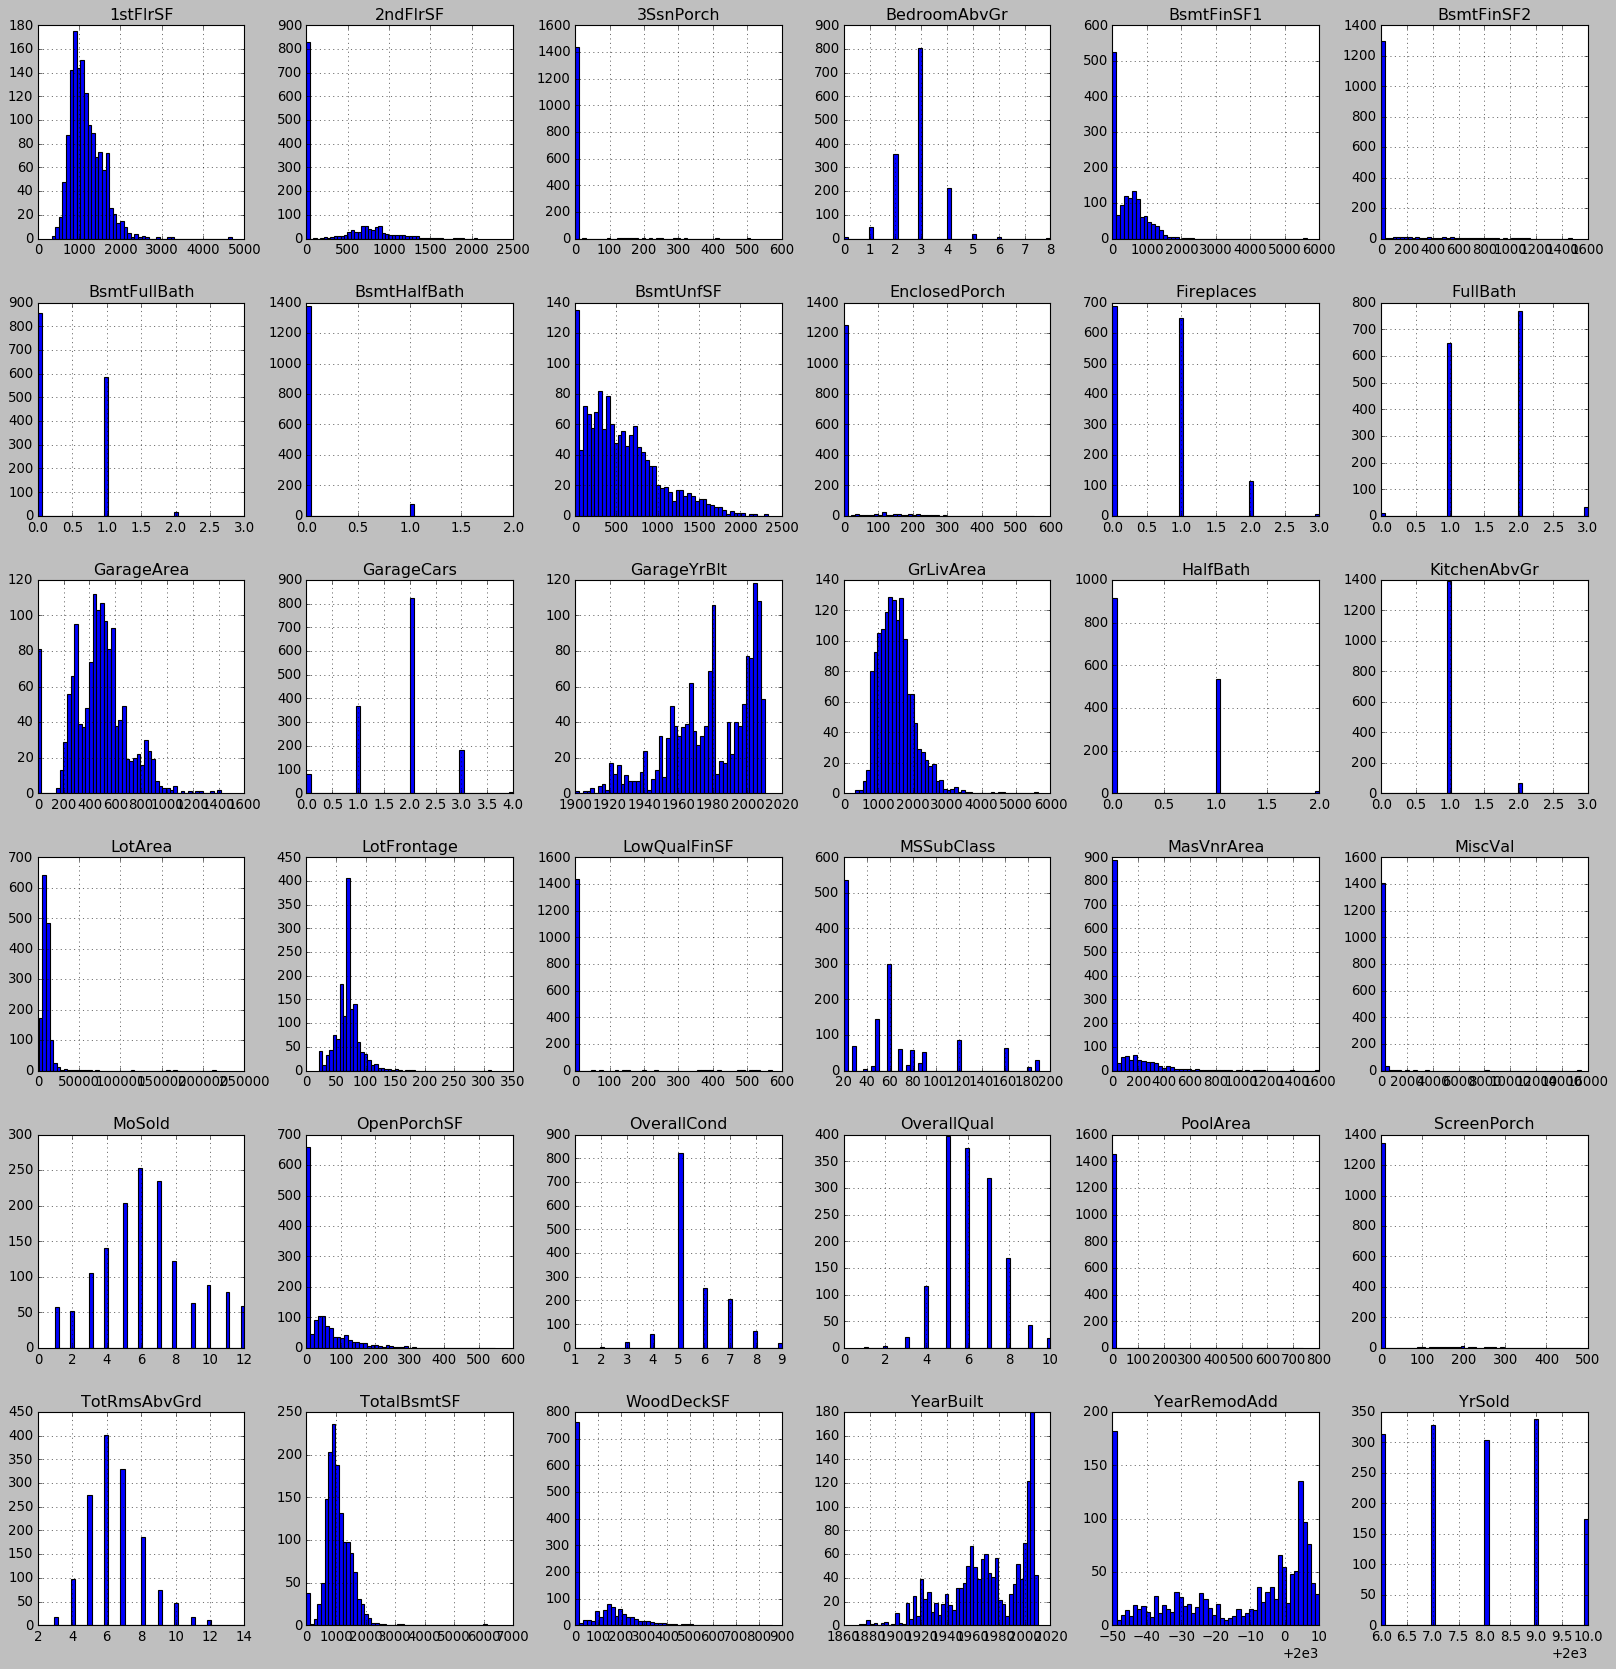

In [11]:
plt.style.use("classic")
continuous_data.hist(bins=50, figsize=(25,25))
plt.show()

## Since many histograms are tail-heavy, we scale data to have bell-shaped distribution. This process is Feature Scaling.

In [12]:
sc_x = StandardScaler()
continuous_data = sc_x.fit_transform(continuous_data)

In [13]:
print(continuous_data)

[[ 0.07337496 -0.22087509 -0.20714171 ... -0.08768781 -1.5991111
   0.13877749]
 [-0.87256276  0.46031974 -0.09188637 ... -0.08768781 -0.48911005
  -0.61443862]
 [ 0.07337496 -0.08463612  0.07347998 ... -0.08768781  0.99089135
   0.13877749]
 ...
 [ 0.30985939 -0.1754621  -0.14781027 ...  4.95311151 -0.48911005
   1.64520971]
 [-0.87256276 -0.08463612 -0.08016039 ... -0.08768781 -0.8591104
   1.64520971]
 [-0.87256276  0.23325479 -0.05811155 ... -0.08768781 -0.1191097
   0.13877749]]


## Cleaning Categorical Data

In [14]:
cat_d = categorical_data.isnull().any()
missing_categorical = list(cat_d[cat_d == True].index)
missing_categorical

['Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [15]:
for i in missing_categorical:
    print(i + " = " + str(categorical_data[i].isna().sum()/1460*100))

Alley = 93.76712328767123
MasVnrType = 0.547945205479452
BsmtQual = 2.5342465753424657
BsmtCond = 2.5342465753424657
BsmtExposure = 2.6027397260273974
BsmtFinType1 = 2.5342465753424657
BsmtFinType2 = 2.6027397260273974
Electrical = 0.0684931506849315
FireplaceQu = 47.26027397260274
GarageType = 5.5479452054794525
GarageFinish = 5.5479452054794525
GarageQual = 5.5479452054794525
GarageCond = 5.5479452054794525
PoolQC = 99.52054794520548
Fence = 80.75342465753424
MiscFeature = 96.30136986301369


In [16]:
drop_categorical = ["Alley", "FireplaceQu", "PoolQC", "Fence", "MiscFeature"]
categorical_data.drop(drop_categorical, axis=1, inplace=True)
categorical_cols = list(categorical_data.columns)

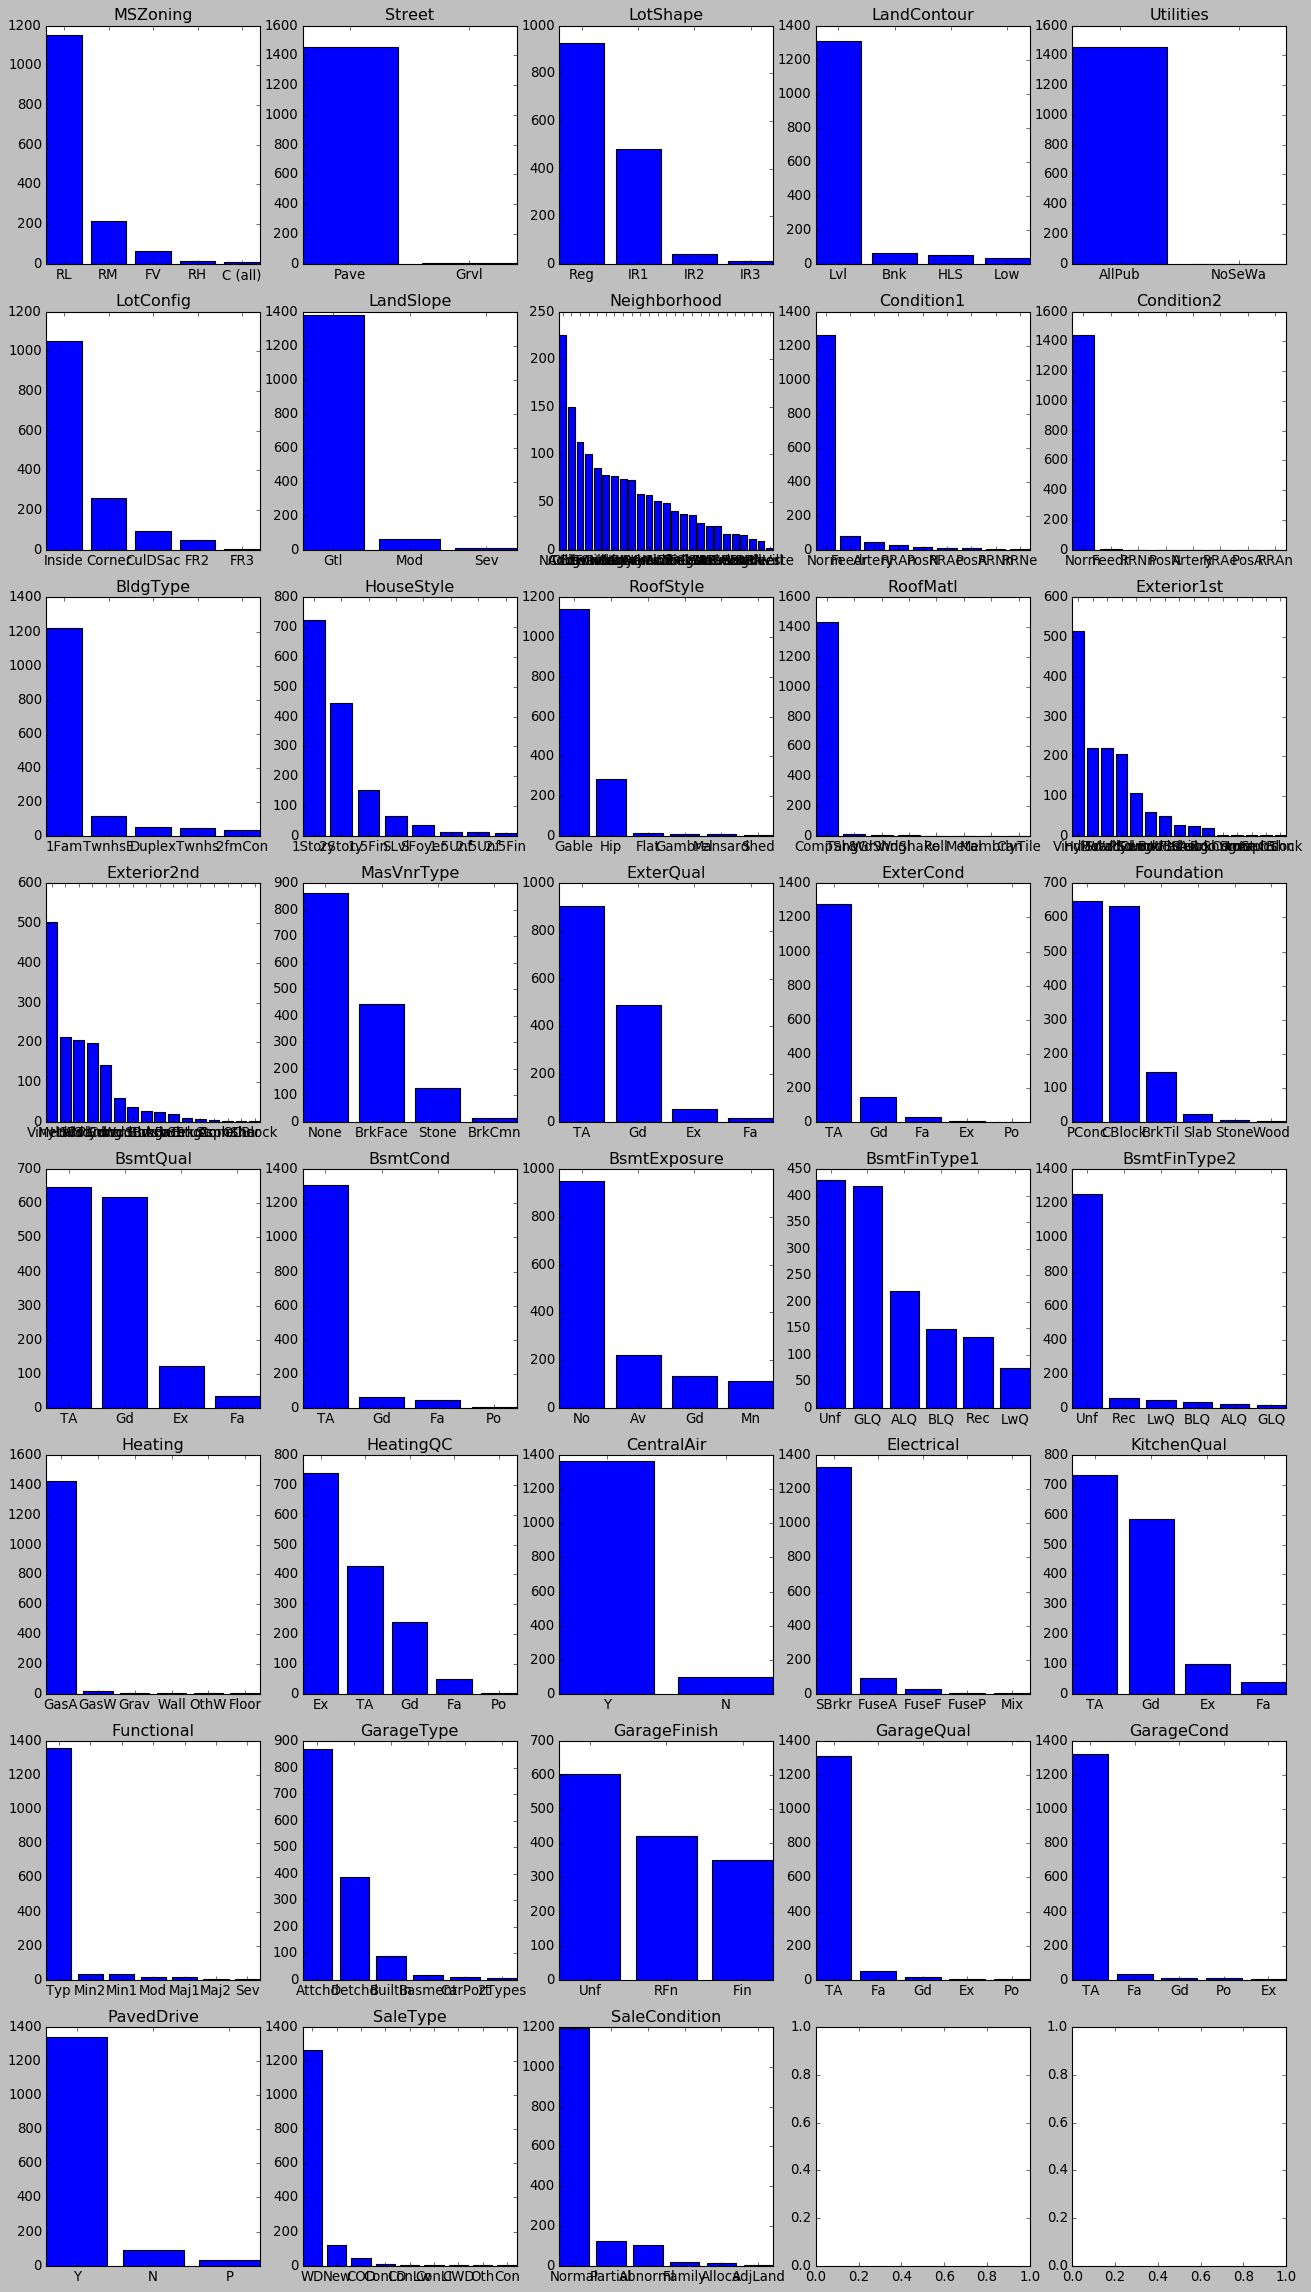

In [17]:
f, axes = plt.subplots(8, 5, figsize=(20, 35))

for ax, col in zip(axes.ravel(), categorical_data.columns):
    target = categorical_data[col].value_counts()
    ax.bar(target.index, target)
    ax.set_title(col)

In [18]:
##Since we see positive skewness, we replace missing values with most frequent value.

categorical_data = categorical_data.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [19]:
##Encoding every column in categorical variable using Label Encoding

for i in categorical_data:
    categorical_data[i] = categorical_data[i].astype('category')
    categorical_data[i] = categorical_data[i].cat.codes
categorical_data.head()


,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,3,1,3,3,0,4,0,5,2,2,...,4,2,6,1,1,4,4,2,8,4
2,3,1,3,3,0,2,0,24,1,2,...,4,3,6,1,1,4,4,2,8,4
3,3,1,0,3,0,4,0,5,2,2,...,4,2,6,1,1,4,4,2,8,4
4,3,1,0,3,0,0,0,6,2,2,...,4,2,6,5,2,4,4,2,8,0
5,3,1,0,3,0,2,0,15,2,2,...,4,2,6,1,1,4,4,2,8,4


In [20]:
print(categorical_data)

      MSZoning  Street  LotShape  LandContour  Utilities  LotConfig  \
Id                                                                    
1            3       1         3            3          0          4   
2            3       1         3            3          0          2   
3            3       1         0            3          0          4   
4            3       1         0            3          0          0   
5            3       1         0            3          0          2   
...        ...     ...       ...          ...        ...        ...   
1456         3       1         3            3          0          4   
1457         3       1         3            3          0          4   
1458         3       1         3            3          0          4   
1459         3       1         3            3          0          4   
1460         3       1         3            3          0          4   

      LandSlope  Neighborhood  Condition1  Condition2  ...  Electrical  \
Id

In [21]:
type(continuous_data)

numpy.ndarray

In [22]:
continuous_data

array([[ 0.07337496, -0.22087509, -0.20714171, ..., -0.08768781,
        -1.5991111 ,  0.13877749],
       [-0.87256276,  0.46031974, -0.09188637, ..., -0.08768781,
        -0.48911005, -0.61443862],
       [ 0.07337496, -0.08463612,  0.07347998, ..., -0.08768781,
         0.99089135,  0.13877749],
       ...,
       [ 0.30985939, -0.1754621 , -0.14781027, ...,  4.95311151,
        -0.48911005,  1.64520971],
       [-0.87256276, -0.08463612, -0.08016039, ..., -0.08768781,
        -0.8591104 ,  1.64520971],
       [-0.87256276,  0.23325479, -0.05811155, ..., -0.08768781,
        -0.1191097 ,  0.13877749]])

In [23]:
data1 = pd.DataFrame(data=continuous_data, columns=continuous_cols)

In [24]:
data1.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.073375,-0.220875,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,...,0.351000,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777
1,-0.872563,0.460320,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,...,-0.060731,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439
2,0.073375,-0.084636,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.288653,...,0.631726,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777
3,0.309859,-0.447940,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,...,0.790804,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655
4,0.073375,0.641972,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,-0.288653,...,1.698485,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777


In [25]:
categorical_data.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,3,1,3,3,0,4,0,5,2,2,...,4,2,6,1,1,4,4,2,8,4
2,3,1,3,3,0,2,0,24,1,2,...,4,3,6,1,1,4,4,2,8,4
3,3,1,0,3,0,4,0,5,2,2,...,4,2,6,1,1,4,4,2,8,4
4,3,1,0,3,0,0,0,6,2,2,...,4,2,6,5,2,4,4,2,8,0
5,3,1,0,3,0,2,0,15,2,2,...,4,2,6,1,1,4,4,2,8,4


In [26]:
new_col = range(1, len(data1) + 1)

In [27]:
data1.insert(loc=0, column='ID', value=new_col)

In [28]:
data1.head()

,ID,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,0.073375,-0.220875,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,...,0.351000,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777
1,2,-0.872563,0.460320,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,...,-0.060731,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439
2,3,0.073375,-0.084636,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,...,0.631726,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777
3,4,0.309859,-0.447940,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,...,0.790804,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655
4,5,0.073375,0.641972,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,...,1.698485,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777


In [29]:
categorical_data.insert(loc=0, column='ID', value=new_col)

In [30]:
categorical_data.head()

,ID,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,1,3,1,3,3,0,4,0,5,2,...,4,2,6,1,1,4,4,2,8,4
2,2,3,1,3,3,0,2,0,24,1,...,4,3,6,1,1,4,4,2,8,4
3,3,3,1,0,3,0,4,0,5,2,...,4,2,6,1,1,4,4,2,8,4
4,4,3,1,0,3,0,0,0,6,2,...,4,2,6,5,2,4,4,2,8,0
5,5,3,1,0,3,0,2,0,15,2,...,4,2,6,1,1,4,4,2,8,4


In [31]:
final_df = pd.merge(left=data1, right=categorical_data, on = "ID")

In [32]:
final_df.head()

,ID,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,1,0.073375,-0.220875,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,...,4,2,6,1,1,4,4,2,8,4
1,2,-0.872563,0.460320,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,...,4,3,6,1,1,4,4,2,8,4
2,3,0.073375,-0.084636,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,...,4,2,6,1,1,4,4,2,8,4
3,4,0.309859,-0.447940,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,...,4,2,6,5,2,4,4,2,8,0
4,5,0.073375,0.641972,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,...,4,2,6,1,1,4,4,2,8,4


In [33]:
sale_price_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [34]:
final_df['SalePrice'] = sale_price_train['SalePrice']

In [35]:
final_df['SalePrice'] = final_df['SalePrice'].shift(-1)

In [36]:
final_df

,ID,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
0,1,0.073375,-0.220875,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,...,2,6,1,1,4,4,2,8,4,208500.0
1,2,-0.872563,0.460320,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,...,3,6,1,1,4,4,2,8,4,181500.0
2,3,0.073375,-0.084636,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,...,2,6,1,1,4,4,2,8,4,223500.0
3,4,0.309859,-0.447940,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,...,2,6,5,2,4,4,2,8,0,140000.0
4,5,0.073375,0.641972,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,...,2,6,1,1,4,4,2,8,4,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,0.073375,-0.357114,-0.260560,-0.071836,-0.517200,0.918511,0.733308,-0.570750,-0.973018,...,3,6,1,1,4,4,2,8,4,175000.0
1456,1457,-0.872563,0.687385,0.266407,-0.071836,0.381743,0.222975,0.151865,0.087911,0.759659,...,3,2,1,2,4,4,2,8,4,210000.0
1457,1458,0.309859,-0.175462,-0.147810,0.651479,3.078570,-1.002492,1.024029,-0.570750,-0.369871,...,2,6,1,1,4,4,2,8,4,266500.0
1458,1459,-0.872563,-0.084636,-0.080160,-0.795151,0.381743,-0.704406,0.539493,-0.570750,-0.865548,...,2,6,1,2,4,4,2,8,4,142125.0


In [37]:
final_df.iloc[1459,-1] = 147500

## Feature Scaling using Correlation matrix

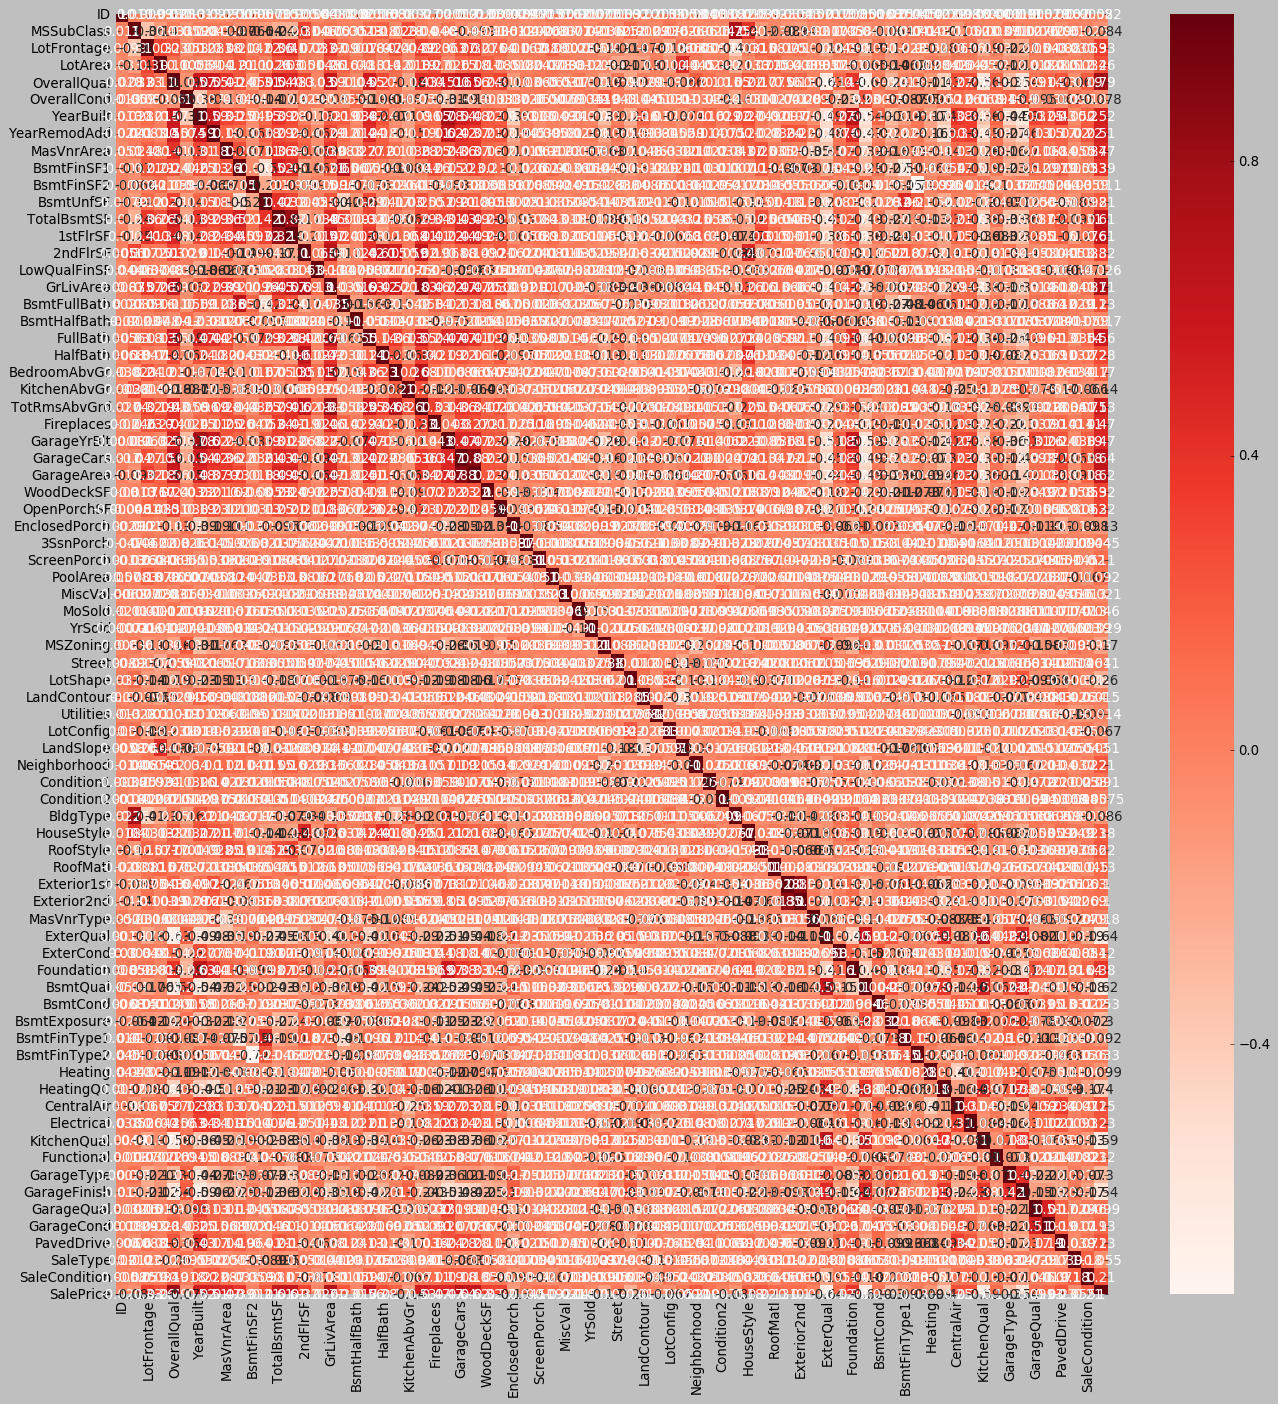

In [38]:
plt.figure(figsize=(20,20))
cor = final_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [39]:
#Correlation with output variable
cor_target = abs(cor["SalePrice"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
TotRmsAbvGrd    0.533723
GarageCars      0.640409
GarageArea      0.623431
ExterQual       0.636884
BsmtQual        0.618025
KitchenQual     0.589189
GarageFinish    0.537242
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [40]:
X_train = final_df[['OverallQual','YearBuilt','YearRemodAdd','TotalBsmtSF','1stFlrSF','GrLivArea','FullBath','TotRmsAbvGrd','GarageCars','GarageArea','ExterQual','BsmtQual','KitchenQual','GarageFinish']]
X_train.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,ExterQual,BsmtQual,KitchenQual,GarageFinish
0,0.651479,1.050994,0.878668,-0.459303,-0.793434,0.370333,0.789741,0.912210,0.311725,0.351000,2,2,2,1
1,-0.071836,0.156734,-0.429577,0.466465,0.257140,-0.482512,0.789741,-0.318683,0.311725,-0.060731,3,2,3,1
2,0.651479,0.984752,0.830215,-0.313369,-0.627826,0.515013,0.789741,-0.318683,0.311725,0.631726,2,2,2,1
3,0.651479,-1.863632,-0.720298,-0.687324,-0.521734,0.383659,-1.026041,0.296763,1.650307,0.790804,3,3,2,2
4,1.374795,0.951632,0.733308,0.199680,-0.045611,1.299326,0.789741,1.527656,1.650307,1.698485,2,2,2,1


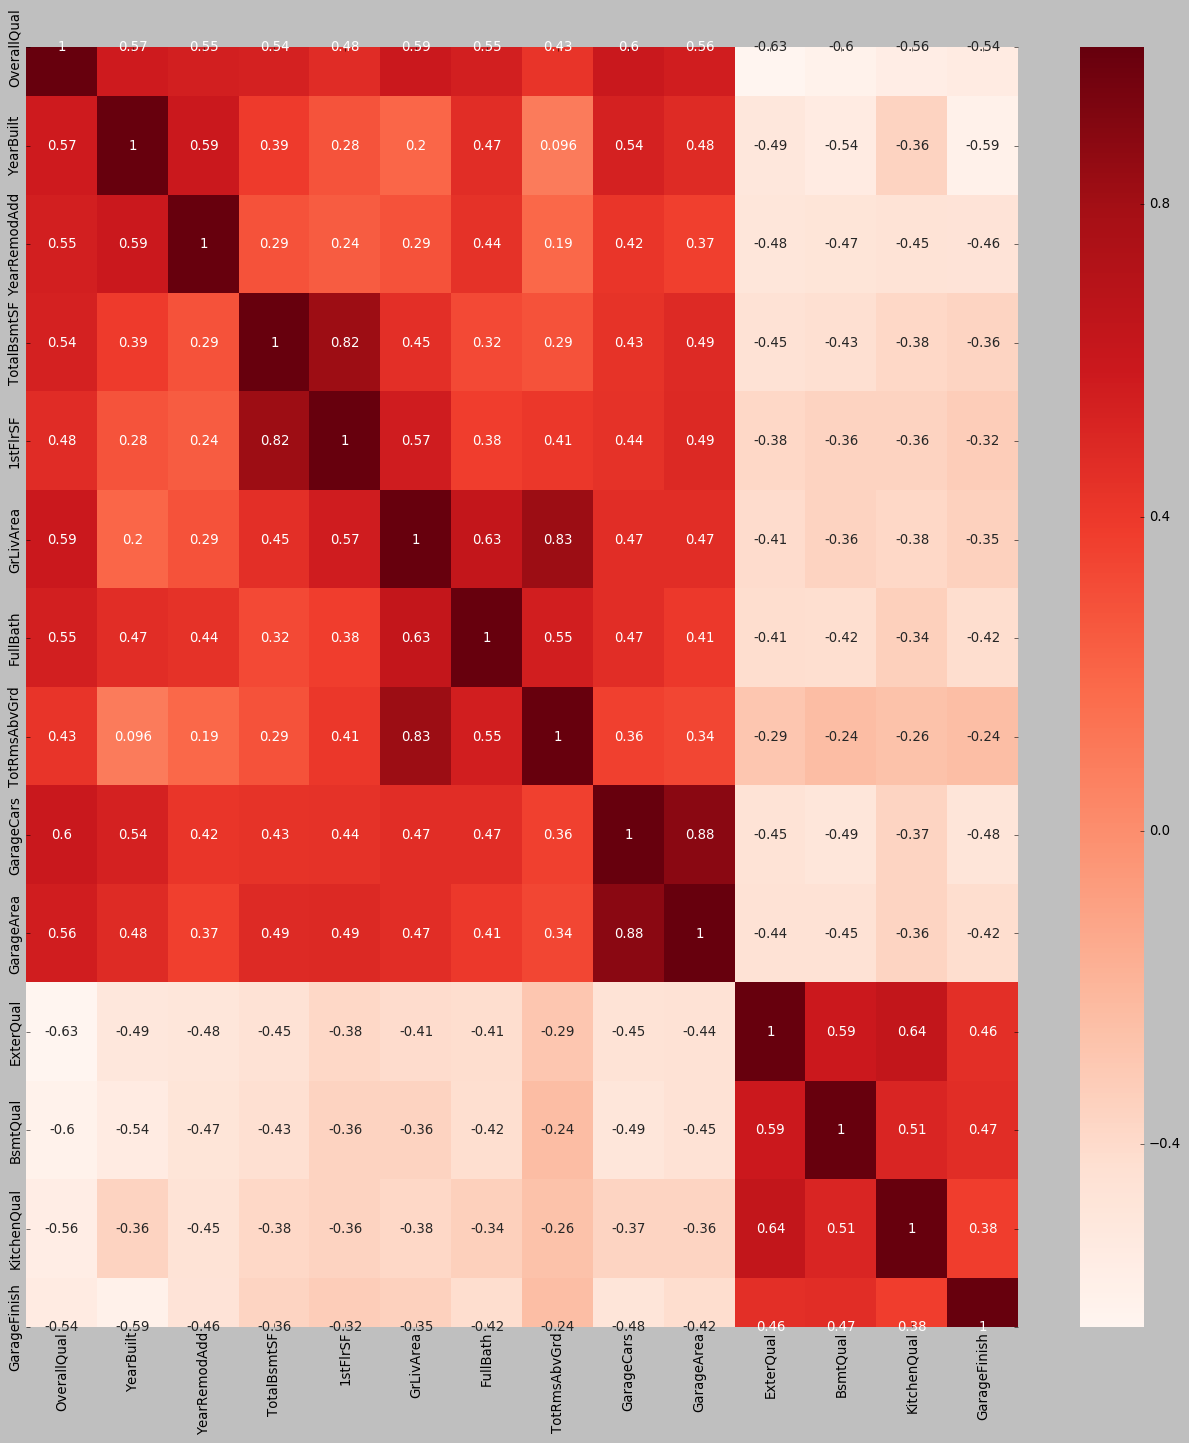

In [41]:
plt.figure(figsize=(20,20))
cor = X_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [42]:
X = X_train.drop(columns = ['ExterQual','KitchenQual'])

## Linear regression implementation


In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics



In [44]:
Y = final_df['SalePrice']
train_x, test_x, train_y, test_y = train_test_split(X,
                                                    Y,
                                                    test_size=0.2,
                                                    random_state=42)

In [45]:
lr = LinearRegression()
lr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [46]:
pred_y = lr.predict(test_x)

In [47]:
mse = metrics.mean_squared_error(test_y, pred_y)
print("Mean Squared Error {}".format(mse))
print("R2 score =", round(metrics.r2_score(test_y, pred_y), 2))
print("Explain variance score =", round(metrics.explained_variance_score(test_y, pred_y), 2)) 

Mean Squared Error 1480737220.6232052
R2 score = 0.81
Explain variance score = 0.81
